In [ ]:
################## PROJECT #################
"""
The program mixed_cap_PARSER_WRDS_DATA_PIOTROSKI.py calculates an approximation to Piotroski's indicator using only ratios.
The program TwoFundamFactors_mod_mixedcap_piotroski_randomforest.py uses this "approximated Piotroski" as one of its inputs.

Modify the program mixed_cap_PARSER_WRDS_DATA_PIOTROSKI.py such that 
it calculates Piotroski using raw fundamental data (instead of ratios)

Use the following inputs for Piotroski's indicator:

1. Positive Net Income
2. Positive return on assets in the current year
3. Positive operating cash flow in the current year
4. Cash flow from operations being greater than net Income
5. Lower ratio of long term debt in the current period, compared to the previous year
6. Higher current ratio this year compared to the previous year
7. No new shares were issued in the last year
8. A higher gross margin compared to the previous year
9. A higher asset turnover ratio compared to the previous year

Calculate Piotroski's indicator as follows: 
For every criteria above met, a stock is awarded one point. 
The points are then added up to determine the value
of the stock, with nine being the highest and zero being the lowest.

For items 1,3,4,5,6,7,8 GOTO
WRDS view: Home/Get Data/CRSP/Annual Update/CRSP/Compustat Merged 
The data is quarterly, so t-4's value corresponds to last year's value. 
Here are the symbols corresponding to the above:
1. NIY>0
3. OANCFY>0  (operating activity-net cash flow)
4. OANCFY>NIY
5. [DLTTQ/ATQ](t)<[DLTTQ/ATQ](t-4)   (DLTTQ: long term debt total, ATQ: assets total)
6. [ACTQ/LCTQ](t)>[ACTQ/LCTQ](t-4)   (ACTQ: current assets total, LCTQ: current liabilities total)
7. CSHOQ(t)<=CSHOQ(t-4)              (CSHOQ: common shares oustanding)
8. [SALEQ-COGSQ](t) - [SALEQ-COGSQ](t-4)    (SALEQ: sales/turnover, COGSQ: cost of goods sold)

To get items 2,9 GOTO:
Home/Get Data/WRDS Analytics/WRDS Analytics/Financial Ratios Suite by WRDS/Financial Ratios/ Firm Level by WRDS (Beta)
The data is monthly, so t-12's value corresponds to last year's value. 
2. roa>0
9. at_turn(t)>at_turn(t-12)

After you modify the program mixed_cap_PARSER_WRDS_DATA_PIOTROSKI.py to include the more accurate raw data
run the program TwoFundamFactors_mod_mixedcap_piotroski_randomforest.py
subtituting the old Piotroski indicator with the newly defined Piotroski indicator
comment on the results

"""

In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('7attributes.csv')
df1['datetime'] = pd.to_datetime(df1['datadate'])
df1.drop(['datadate', 'GVKEY', 'fyearq', 'fqtr', 'conm'], axis=1, inplace=True)
df1 = df1.rename(columns = {'LPERMNO':'permno'})
df1.sort_values(by=["permno","datetime"], inplace=True)
df1.head()

,permno,actq,atq,cogsq,cshoq,dlttq,lctq,saleq,niy,oancfy,datetime
4506,10026,281.308,709.313,148.700,18.689,1.334,90.171,225.008,25.893,31.228,2015-03-31
4507,10026,333.708,742.926,178.970,18.692,1.265,105.569,278.724,50.355,68.606,2015-06-30
4508,10026,326.783,742.935,167.655,18.676,1.196,97.116,259.772,70.183,105.273,2015-09-30
4509,10026,305.253,741.638,149.516,18.677,1.126,94.211,222.850,12.978,20.918,2015-12-31
4510,10026,303.828,745.107,151.042,18.617,1.418,95.729,229.710,28.566,28.301,2016-03-31


In [2]:
# df1: calculate score for each column/attribute (max=7)
n=4 # quarterly data
df1['piotroski_niy'] = np.where(df1.niy > 0, 1, 0)
df1['piotroski_oancfy'] = np.where(df1.oancfy > 0, 1, 0)
df1['piotroski_oancfy_niy'] = np.where(df1.oancfy > df1.niy, 1, 0)
df1['piotroski_dlttq'] = np.where((df1.permno == df1.permno.shift(n)) & ((df1.dlttq/df1.atq)<(df1.dlttq.shift(n)/df1.atq.shift(n))), 1, 0)
df1['piotroski_curr'] = np.where((df1.permno == df1.permno.shift(n)) & ((df1.actq/df1.lctq)>(df1.actq.shift(n)/df1.lctq.shift(n))), 1, 0)
df1['piotroski_cshoq'] = np.where((df1.permno == df1.permno.shift(n)) & (df1.cshoq<=df1.actq.shift(n)), 1, 0)
df1['piotroski_sc'] = np.where((df1.permno == df1.permno.shift(n)) & ((df1.saleq-df1.cogsq)>(df1.saleq.shift(n)-df1.cogsq.shift(n))), 1, 0)
df1.head()

,permno,actq,atq,cogsq,cshoq,dlttq,lctq,saleq,niy,oancfy,datetime,piotroski_niy,piotroski_oancfy,piotroski_oancfy_niy,piotroski_dlttq,piotroski_curr,piotroski_cshoq,piotroski_sc
4506,10026,281.308,709.313,148.700,18.689,1.334,90.171,225.008,25.893,31.228,2015-03-31,1,1,1,0,0,0,0
4507,10026,333.708,742.926,178.970,18.692,1.265,105.569,278.724,50.355,68.606,2015-06-30,1,1,1,0,0,0,0
4508,10026,326.783,742.935,167.655,18.676,1.196,97.116,259.772,70.183,105.273,2015-09-30,1,1,1,0,0,0,0
4509,10026,305.253,741.638,149.516,18.677,1.126,94.211,222.850,12.978,20.918,2015-12-31,1,1,1,0,0,0,0
4510,10026,303.828,745.107,151.042,18.617,1.418,95.729,229.710,28.566,28.301,2016-03-31,1,1,0,0,1,1,1


In [3]:
df2 = pd.read_csv('2attributes.csv')
df2['datetime'] = pd.to_datetime(df2['public_date'])
df2.drop(['public_date', 'adate', 'qdate'], axis=1, inplace=True)
df2.sort_values(by=["permno","datetime"], inplace=True)
df2.head()

,permno,roa,roe,at_turn,datetime
0,10026,0.214,0.123,1.362,2015-01-31
1,10026,0.209,0.120,1.340,2015-02-28
2,10026,0.209,0.120,1.340,2015-03-31
3,10026,0.209,0.120,1.340,2015-04-30
4,10026,0.209,0.120,1.348,2015-05-31


In [4]:
# df2: calculate score for each column/attribute (max=2)
n=12
df2['piotroski_roa'] = np.where(df2.roa > 0, 1, 0)
df2['piotroski_at_turn'] = np.where((df2.permno == df2.permno.shift(n)) & (df2.at_turn>df2.at_turn.shift(n)), 1, 0)
df2.head()

,permno,roa,roe,at_turn,datetime,piotroski_roa,piotroski_at_turn
0,10026,0.214,0.123,1.362,2015-01-31,1,0
1,10026,0.209,0.120,1.340,2015-02-28,1,0
2,10026,0.209,0.120,1.340,2015-03-31,1,0
3,10026,0.209,0.120,1.340,2015-04-30,1,0
4,10026,0.209,0.120,1.348,2015-05-31,1,0


In [5]:
df1.permno.unique().sum()

58810976

In [6]:
df2.permno.unique().sum()

53115534

### Merge df1 and df2 to dffac using 'Left Join'

In [7]:
dffac = pd.merge(df2, df1, on = ['permno', 'datetime'], how="left") 
dffac.sort_values(by=["permno","datetime"], inplace=True) 
dffac.head()

,permno,roa,roe,at_turn,datetime,piotroski_roa,piotroski_at_turn,actq,atq,cogsq,...,saleq,niy,oancfy,piotroski_niy,piotroski_oancfy,piotroski_oancfy_niy,piotroski_dlttq,piotroski_curr,piotroski_cshoq,piotroski_sc
0,10026,0.214,0.123,1.362,2015-01-31,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10026,0.209,0.120,1.340,2015-02-28,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10026,0.209,0.120,1.340,2015-03-31,1,0,281.308,709.313,148.7,...,225.008,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,10026,0.209,0.120,1.340,2015-04-30,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10026,0.209,0.120,1.348,2015-05-31,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dffac.isnull().sum().sum()

449684

In [9]:
# filling NaN values
dffac.fillna(method='ffill', axis=0, inplace=True) #filling in for days where a price does not exist
dffac.fillna(method='bfill', axis=0, inplace=True) #filling in for days where a price does not exist
dffac.head()

,permno,roa,roe,at_turn,datetime,piotroski_roa,piotroski_at_turn,actq,atq,cogsq,...,saleq,niy,oancfy,piotroski_niy,piotroski_oancfy,piotroski_oancfy_niy,piotroski_dlttq,piotroski_curr,piotroski_cshoq,piotroski_sc
0,10026,0.214,0.123,1.362,2015-01-31,1,0,281.308,709.313,148.7,...,225.008,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,10026,0.209,0.120,1.340,2015-02-28,1,0,281.308,709.313,148.7,...,225.008,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,10026,0.209,0.120,1.340,2015-03-31,1,0,281.308,709.313,148.7,...,225.008,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,10026,0.209,0.120,1.340,2015-04-30,1,0,281.308,709.313,148.7,...,225.008,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,10026,0.209,0.120,1.348,2015-05-31,1,0,281.308,709.313,148.7,...,225.008,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [10]:
dffac.isnull().sum()

permno                  0
roa                     0
roe                     0
at_turn                 0
datetime                0
piotroski_roa           0
piotroski_at_turn       0
actq                    0
atq                     0
cogsq                   0
cshoq                   0
dlttq                   0
lctq                    0
saleq                   0
niy                     0
oancfy                  0
piotroski_niy           0
piotroski_oancfy        0
piotroski_oancfy_niy    0
piotroski_dlttq         0
piotroski_curr          0
piotroski_cshoq         0
piotroski_sc            0
dtype: int64

In [11]:
dffac['piotroski'] = dffac['piotroski_niy']+dffac['piotroski_oancfy']+dffac['piotroski_oancfy_niy']\
        +dffac['piotroski_dlttq']+dffac['piotroski_curr']+dffac['piotroski_cshoq']+dffac['piotroski_sc']+dffac['piotroski_roa']\
        +dffac['piotroski_at_turn']
dffac.head()

,permno,roa,roe,at_turn,datetime,piotroski_roa,piotroski_at_turn,actq,atq,cogsq,...,niy,oancfy,piotroski_niy,piotroski_oancfy,piotroski_oancfy_niy,piotroski_dlttq,piotroski_curr,piotroski_cshoq,piotroski_sc,piotroski
0,10026,0.214,0.123,1.362,2015-01-31,1,0,281.308,709.313,148.7,...,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0
1,10026,0.209,0.120,1.340,2015-02-28,1,0,281.308,709.313,148.7,...,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0
2,10026,0.209,0.120,1.340,2015-03-31,1,0,281.308,709.313,148.7,...,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0
3,10026,0.209,0.120,1.340,2015-04-30,1,0,281.308,709.313,148.7,...,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0
4,10026,0.209,0.120,1.348,2015-05-31,1,0,281.308,709.313,148.7,...,25.893,31.228,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0


## Data Exploration on Piotroski Score

In [12]:
dffac['piotroski'].value_counts()

6.0    8396
7.0    8092
4.0    8077
5.0    5888
8.0    4359
3.0    3750
2.0    1484
9.0    1113
1.0     393
0.0      51
Name: piotroski, dtype: int64

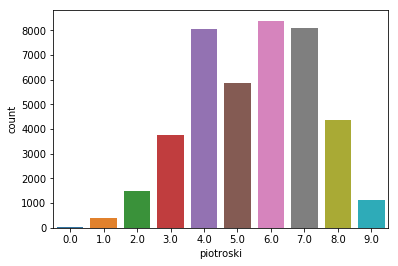

In [16]:
import seaborn as sns
sns.countplot(dffac['piotroski'])

In [17]:
grouped = dffac.groupby('permno')['piotroski'].mean()

In [18]:
# top 5 permnos
grouped.sort_values(ascending=False)[:5]

permno
90427    7.208333
13837    7.062500
15014    6.916667
38659    6.895833
62498    6.875000
Name: piotroski, dtype: float64

In [19]:
# bottom 5 permnos
grouped.sort_values(ascending=False)[-5:]

permno
77515    2.333333
45728    2.333333
89796    2.145833
18048    2.000000
18065    2.000000
Name: piotroski, dtype: float64

In [20]:
#dffac.to_csv('9factors.csv')

In [21]:
#Use the permno to get to bid ask end of day (eventually mid_prices)
#GOTO: Home/WRDS/CRSP/Stock/SecurityFiles/DailyStockFile/
#Use as input: permno_ticker_wrds.txt
#the output of WRDS: permno_ticker_prc_bid_ask_wrds.csv

dfprice = pd.read_csv("price.csv", names=["permno","date","ticker","prc","bid", "ask"], header=0)
dfprice.head()

,permno,date,ticker,prc,bid,ask
0,10026,01/02/2015,JJSF,107.69,107.45,107.69
1,10026,01/05/2015,JJSF,107.24,107.25,107.39
2,10026,01/06/2015,JJSF,107.27,107.25,107.55
3,10026,01/07/2015,JJSF,108.73,108.62,108.75
4,10026,01/08/2015,JJSF,110.32,110.31,110.71


In [22]:
dfprice["datetime"] = pd.to_datetime(dfprice["date"])
dfprice.sort_values(by=["permno","datetime"], inplace=True)
df = dfprice.loc[:, ['permno','datetime','prc', 'bid', 'ask']]
df.sort_values(by=["permno","datetime"], inplace=True)
df.drop(['permno', 'datetime'], axis=1, inplace=True)
df.fillna(method='ffill', axis=1, inplace=True) #forward filling across, from prc onto bid onto ask

In [23]:
dfprice["bid"] = df.bid
dfprice["ask"] = df.ask
dfprice["prc"] = df.prc
dfprice["mid_price"] = (dfprice.bid+dfprice.ask)/2
dfprice.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
dfprice.head()
#dfprice.to_csv("mixed_cap_daily_prices.csv") #check that everything is ok, daily prices 

,permno,date,ticker,prc,bid,ask,datetime,mid_price
0,10026,01/02/2015,JJSF,107.69,107.45,107.69,2015-01-02,107.570
1,10026,01/05/2015,JJSF,107.24,107.25,107.39,2015-01-05,107.320
2,10026,01/06/2015,JJSF,107.27,107.25,107.55,2015-01-06,107.400
3,10026,01/07/2015,JJSF,108.73,108.62,108.75,2015-01-07,108.685
4,10026,01/08/2015,JJSF,110.32,110.31,110.71,2015-01-08,110.510


In [24]:
#now merge dfprice and dffac by outer join
#and result becomes daily  data with as many NaNs as necessary
dffacprice = pd.merge(dfprice,dffac,how="outer") 
dffacprice.sort_values(by=["permno","datetime"], inplace=True) #this is daily data, like the prices
df = dffacprice.loc[:, ['permno','datetime','prc', 'bid', 'ask', 'mid_price']]
df.sort_values(by=["permno","datetime"], inplace=True)
df.drop(['permno', 'datetime'], axis=1, inplace=True)
df.fillna(method='ffill', axis=0, inplace=True) #filling in for days where a price does not exist
dffacprice["bid"] = df.bid
dffacprice["ask"] = df.ask
dffacprice["prc"] = df.prc
dffacprice["mid_price"]=df.mid_price
dffacprice.head()

,permno,date,ticker,prc,bid,ask,datetime,mid_price,roa,roe,...,niy,oancfy,piotroski_niy,piotroski_oancfy,piotroski_oancfy_niy,piotroski_dlttq,piotroski_curr,piotroski_cshoq,piotroski_sc,piotroski
0,10026,01/02/2015,JJSF,107.69,107.45,107.69,2015-01-02,107.570,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10026,01/05/2015,JJSF,107.24,107.25,107.39,2015-01-05,107.320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10026,01/06/2015,JJSF,107.27,107.25,107.55,2015-01-06,107.400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10026,01/07/2015,JJSF,108.73,108.62,108.75,2015-01-07,108.685,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10026,01/08/2015,JJSF,110.32,110.31,110.71,2015-01-08,110.510,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
dffacprice.drop(['date'], axis=1, inplace=True)
dffacprice.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
#dffacprice.to_csv("mixed_cap_daily_pietroski_factors_and_prices.csv") 
#del dfprice
#del dffac

In [26]:
dffacprice.tail()

,permno,ticker,prc,bid,ask,datetime,mid_price,roa,roe,at_turn,...,niy,oancfy,piotroski_niy,piotroski_oancfy,piotroski_oancfy_niy,piotroski_dlttq,piotroski_curr,piotroski_cshoq,piotroski_sc,piotroski
969702,93427,FN,46.91,46.84,46.91,2018-12-24,46.875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969703,93427,FN,49.59,49.59,49.60,2018-12-26,49.595,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969704,93427,FN,49.68,49.67,49.68,2018-12-27,49.675,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969705,93427,FN,50.74,50.70,50.73,2018-12-28,50.715,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969706,93427,FN,51.31,51.30,51.31,2018-12-31,51.305,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#how many permnos have we got?
dfpermno = pd.DataFrame(dffacprice.permno) #these permnos are filtered (have factors and prices associated)
dfpermno = dfpermno.drop_duplicates()
dfpermno.sort_values(by=["permno"], inplace=True) 
dfpermno = pd.DataFrame(dfpermno.values, columns=["permno"]) #reindex didnt work
dfpermno.to_csv("mixed_cap_permnos_with_wrds_data_new.csv") #(597, 1) permnos

In [28]:
#UNSTACKING THE Piotroskis    
dfpio = dffacprice.loc[dffacprice.permno==dfpermno.iloc[0][0],['piotroski', 'datetime']]
dfpio.index = dfpio.datetime
dfpio.drop(['datetime'], axis=1, inplace=True)

In [29]:
for i in range(dfpermno.shape[0]):
    if i>0:
        dfpio2=dffacprice.loc[dffacprice.permno==dfpermno.iloc[i][0],['piotroski', 'datetime']]
        dfpio2.index = dfpio2.datetime
        dfpio2.drop(['datetime'], axis=1, inplace=True)
        dfpio=pd.concat([dfpio,dfpio2], axis=1)

dfpio.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
dfpio.to_csv("mixed_cap_piotroski_UNSTACKED_new.csv")
#del dfpio

In [30]:
#UNSTACKING THE roe (not part of pietroski)
dfroe = dffacprice.loc[dffacprice.permno==dfpermno.iloc[0][0],['roe', 'datetime']]
dfroe.index = dfroe.datetime
dfroe.drop(['datetime'], axis=1, inplace=True)
for i in range(dfpermno.shape[0]):
    if i>0:
        dfroe2=dffacprice.loc[dffacprice.permno==dfpermno.iloc[i][0],['roe', 'datetime']]
        dfroe2.index = dfroe2.datetime
        dfroe2.drop(['datetime'], axis=1, inplace=True)
        dfroe=pd.concat([dfroe,dfroe2], axis=1)

dfroe.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
dfroe.to_csv("mixed_cap_roe_UNSTACKED_new.csv")
#del dfroe

In [31]:
#UNSTACKING THE mid_price   
dfmp = dffacprice.loc[dffacprice.permno==dfpermno.iloc[0][0],['mid_price', 'datetime']]
dfmp.index = dfmp.datetime
dfdatesmp = dfmp.datetime
dfmp.drop(['datetime'], axis=1, inplace=True)
for i in range(dfpermno.shape[0]):
    if i>0:
        dfmp2=dffacprice.loc[dffacprice.permno==dfpermno.iloc[i][0],['mid_price', 'datetime']]
        dfmp2.index = dfmp2.datetime
        dfmp2.drop(['datetime'], axis=1, inplace=True)
        dfmp=pd.concat([dfmp,dfmp2], axis=1)

dfmp.fillna(method='ffill', axis=0, inplace=True) #forward filling down
dfmp.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
dfmp.to_csv("mixed_cap_mid_price_UNSTACKED_new.csv")
#dfdatesmp.to_csv("mixed_cap_dates_UNSTACKED.csv")

In [32]:
#how many tickers have we got?
dfticker = pd.DataFrame(dffacprice.ticker) #these tickers are filtered (have factors and prices associated)
dfticker = dfticker.drop_duplicates()
dfticker.sort_values(by=["ticker"], inplace=True) 
dfticker = pd.DataFrame(dfticker.values, columns=["ticker"]) #reindex didnt work
#dfticker.to_csv("mixed_cap_tickers_with_wrds_data.csv") #(636, 1) tickers
#del dfticker

In [ ]:
#have no idea why the number of tickers differs from the number of permnos
#code to chekc for nulls
#dffacprice[dffacprice.isnull().any(axis=1)]
#dffacprice.loc[dffacprice['bid'].isnull()]
#dfY.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
#data = dffac.copy()
#data =data[~data.isin([np.inf, -np.inf]).any(1)]

"""
#tests on madeup data

bm=pd.read_csv("bm.csv")
price=pd.read_csv("price.csv")
bmpr=pd.merge(bm,price, how="outer")


bm1=pd.read_csv("bm1.csv")
bm2=pd.read_csv("bm2.csv")
bm1.index=bm1.datetime
bm2.index=bm2.datetime
bmall=pd.concat([bm1,bm2], axis=1)
bmaonly=bmall.bm

np.iinfo(np.int64)
Out[27]: iinfo(min=-9223372036854775808, max=9223372036854775807, dtype=int64)
"""

In [ ]:
"""
Piotroski is defined as:

1. Positive Net Income
2. Positive return on assets in the current year
3. Positive operating cash flow in the current year
4. Cash flow from operations being greater than net Income
5. Lower ratio of long term debt in the current period, compared to the previous year
6. Higher current ratio this year compared to the previous year
7. No new shares were issued in the last year
8. A higher gross margin compared to the previous year
9. A higher asset turnover ratio compared to the previous year

For every criteria below met, a stock is awarded one point. The points are then added up to determine the value
of the stock, with nine being the highest and zero being the lowest

We lacked 1, 3, 5 and 7 because these are not found in the WRDS section of financial ratios. Instead we substituted 1, 3, 5 and 7 as follows:

1. roa delta (should be positive)
2. roa (should be positive)
3. cofra (should be positive)
4. cofra > roa (should be true)
5. a. debt_assets delta (should be negative)
5. b. debt_invcap delta (should be negative) 
6. curr_ratio delta change (should be positive)
7.a. change in issuance = total debt/equity: de _ratio delta (should be zero or positive)
7.b. change in issuance2 = long term debt/book equity:dltt_be delta change (should be zero or positive) 
8. A higher gross margin compared to the previous year gpm_delta
9. A higher asset turnover ratio compared to the previous year: at_turn_delta


where delta = change from previous year
cofra was calculated by multiplying 3 ratios:
cofra=operating CF/total assets = operating CF/current liabilities*current liabilities/total liabilities*total liabilities/total tangible assets (this is an approximation)
"""